## 0. Importing external modules

In [1]:
## magics

%load_ext version_information 
%version_information numpy,xarray,netCDF4,matplotlib


Software versions
Python 2.7.15 64bit [GCC 7.2.0]
IPython 4.2.0
OS Linux 3.16.0 4 amd64 x86_64 with debian 8.5
numpy 1.11.2
xarray 0.10.4
netCDF4 1.4.0
matplotlib 2.2.2
Mon May 28 16:24:33 2018 CEST

In [2]:
## path for mdules

import sys
sys.path.insert(0,"/home/albert/lib/python")

In [3]:
## imports

import numpy as np
import xarray as xr
import GriddedData
import time

In [4]:
#- Other modules
import numpy.ma as ma
import WavenumberSpectrum as ws

### palette
import matplotlib.cm as mplcm

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

### quick plot
import matplotlib.pyplot as plt

## local/specific imports
import oocgcm
import oocgcm.filtering
import oocgcm.filtering.linearfilters as tf
%matplotlib inline

In [5]:
dirin="/media/extra/DATA/NATL60/NATL60-I/"
gridfile=dirin+"NATL60_v4.1_cdf_mesh_hgr.nc"
!ls $gridfile
grid=xr.open_dataset(gridfile)
navlat= np.squeeze(grid['nav_lat'])
navlon= np.squeeze(grid['nav_lon'])


/media/extra/DATA/NATL60/NATL60-I/NATL60_v4.1_cdf_mesh_hgr.nc


In [6]:
def fine_scale_variance(files):
    ''' from a list of files containing one month of data compute variance and average in 1°x1°x1 month boxes
    '''
    hpcurl = xr.open_mfdataset(files,concat_dim='time_counter',decode_times=False)['socurloverf_filt']
    hpcurl2 = hpcurl ** 2
    hpcurl2m = hpcurl2.mean(axis=0,keep_attrs=True)
    navlat2=np.array(navlat).squeeze()
    navlon2=np.array(navlon).squeeze()
    mgrd = GriddedData.grid2D(navlat=navlat2, navlon=navlon2)
    crs = GriddedData.grdCoarsener(mgrd,crs_factor=60)
    hpcurl2mc = crs.return_ravel(np.asarray(hpcurl2m))
    hpcurl2mcm = np.mean(hpcurl2mc,axis=-3)
    latcrs=crs.return_ravel(np.asarray(navlat2))
    loncrs=crs.return_ravel(np.asarray(navlon2))
    latcrsm=np.mean(latcrs,axis=-3)
    loncrsm=np.mean(loncrs,axis=-3)
    return loncrsm,latcrsm,hpcurl2mcm,hpcurl2m



In [8]:
def plot_fine_scale_variance(var,loncrs,latcrs,lon,lat,hpvarm,month):
    ''' map of the averaged fine scale variance
    '''
    fig = plt.figure(figsize=(15,11))
    ax = plt.subplot(111)
    ax.autoscale(tight=True)
    cont=np.isnan(hpvarm)

    pcolor = ax.pcolormesh(loncrs,latcrs,ma.masked_invalid(var),cmap=seq_cmap,vmin=0,vmax=0.1,alpha=1)
    ax.tick_params(labelsize=25)
    ax.contour(lon,lat,cont,alpha=0.5,linewidth=0.000001,antialiased=True)
    cbar = plt.colorbar(pcolor,orientation='horizontal',pad=0.1)
    cbar.ax.tick_params(labelsize=35)
    ax.set_xlabel('Longitude (in degree)',fontsize=20)
    ax.set_ylabel('Latitude (in degree)',fontsize=20)
    cbar.ax.tick_params(labelsize=25)
    cbar.set_label('Small scales relative vorticity variance in '+month,fontsize=25)
    plt.savefig('fine_scale_variance_socurloverf_NATL60-CJM165_'+month+'.png')
      


/home/albert/anaconda2/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


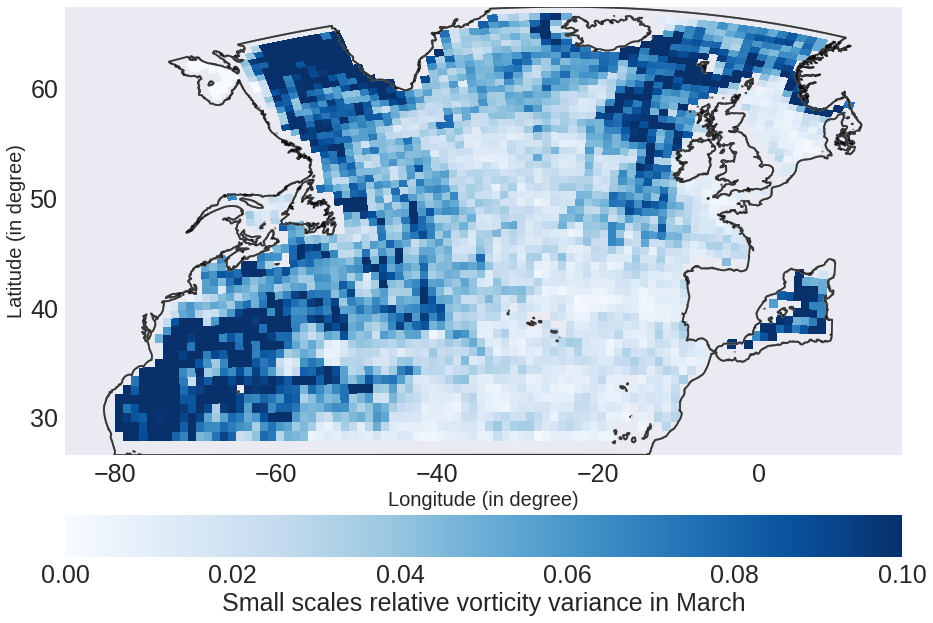

In [9]:
dir="/media/extra/DATA/NATL60/NATL60-CJM165-S/filt/"

filt_files03="NATL60-CJM165_y2013m03d*.1d_curloverf_filt-n80-f0.0125.nc"
tf_files03=dir+filt_files03
loncrsm03, latcrsm03, boxvarcurl03, hpvarm03 = fine_scale_variance(tf_files03)
plot_fine_scale_variance(boxvarcurl03,loncrsm03, latcrsm03,navlon,navlat,hpvarm03,'March')

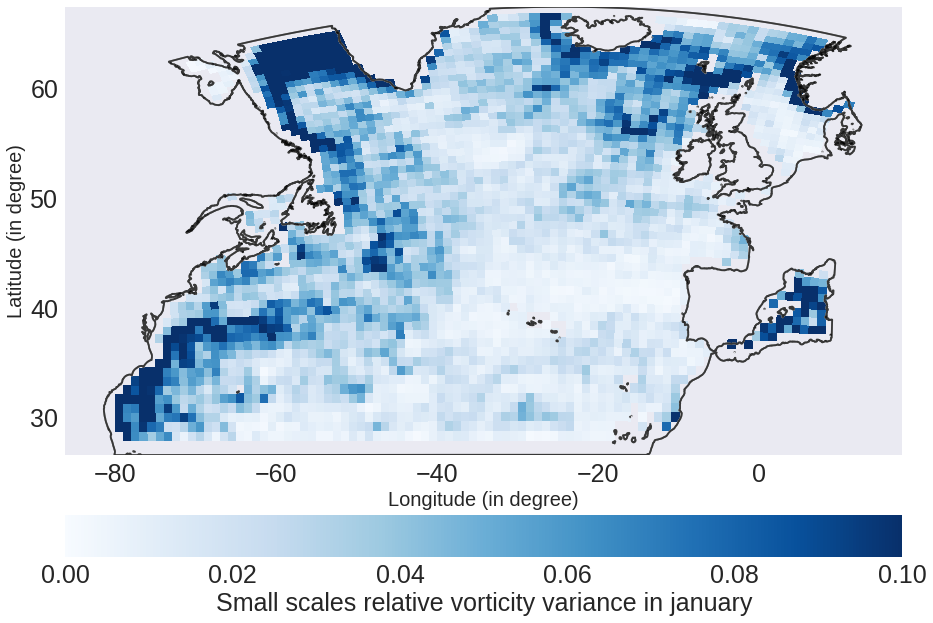

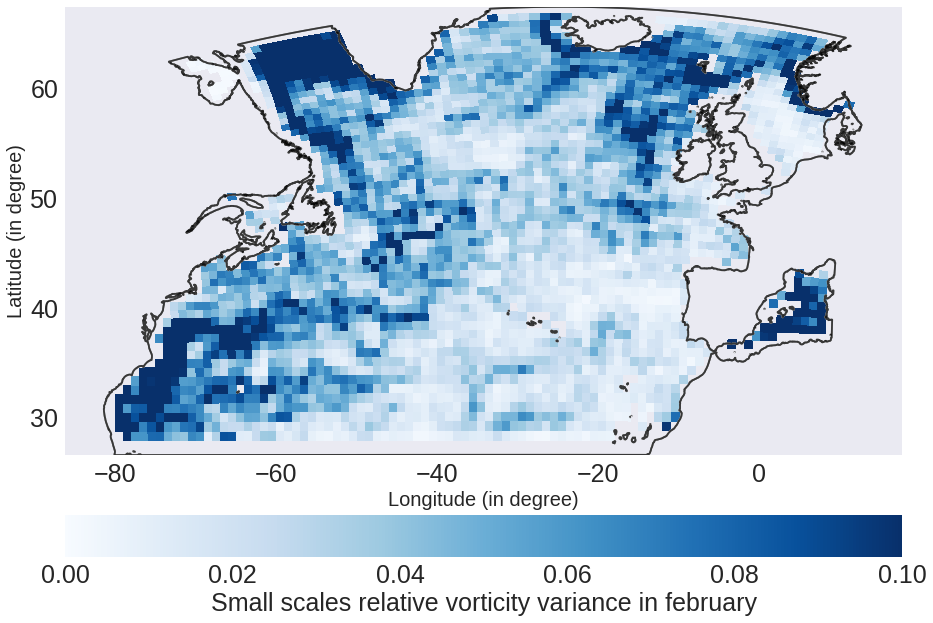

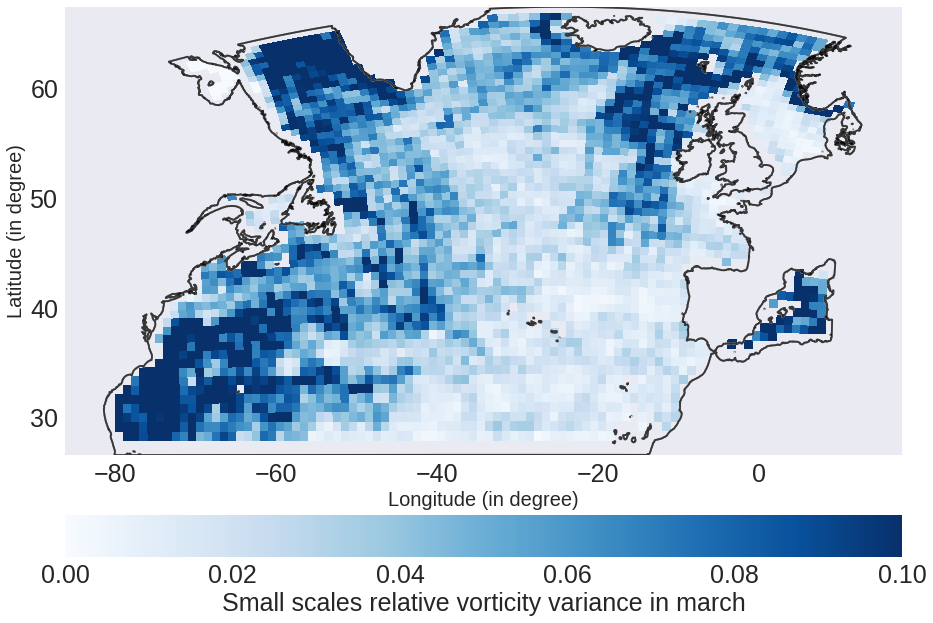

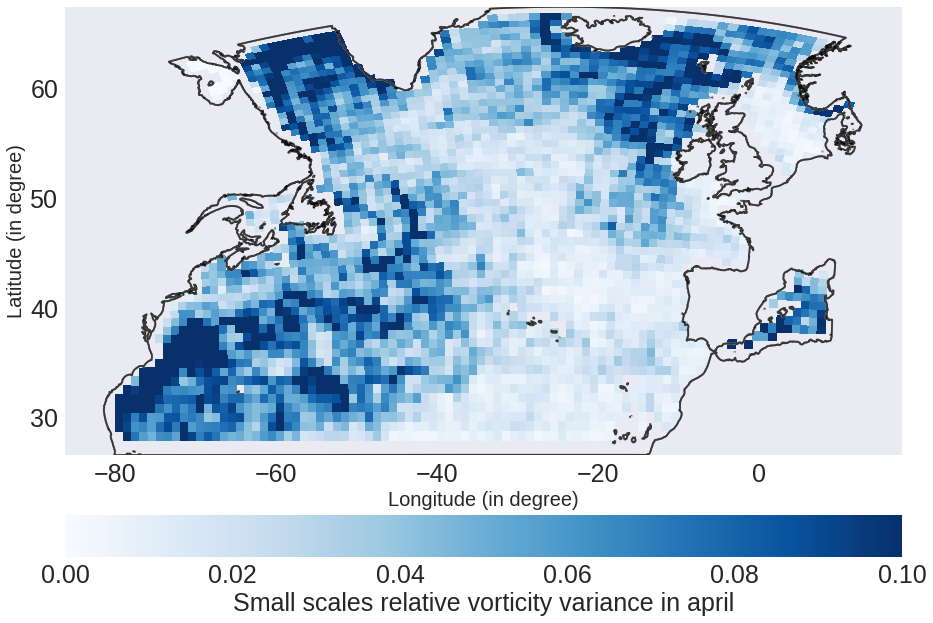

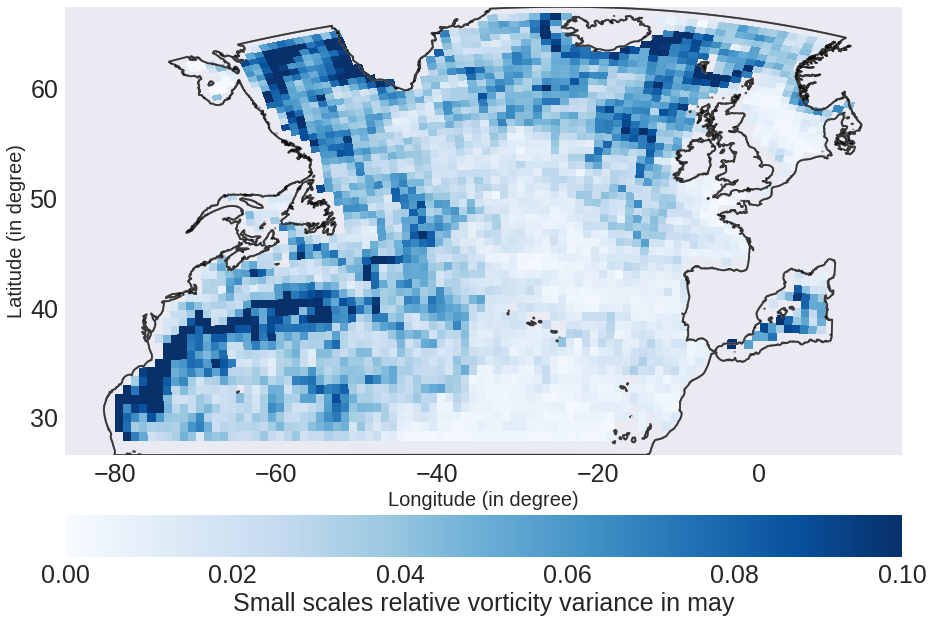

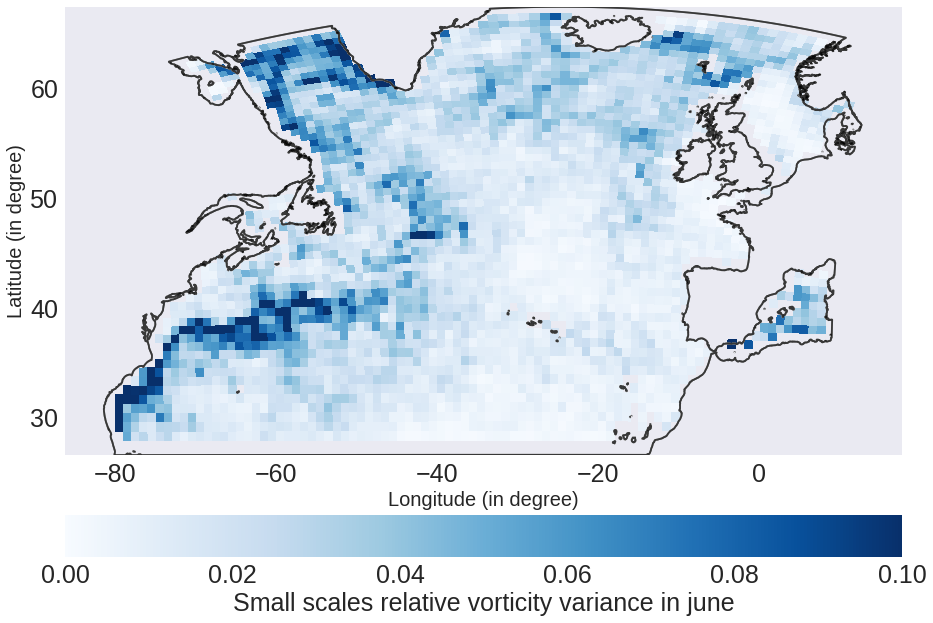

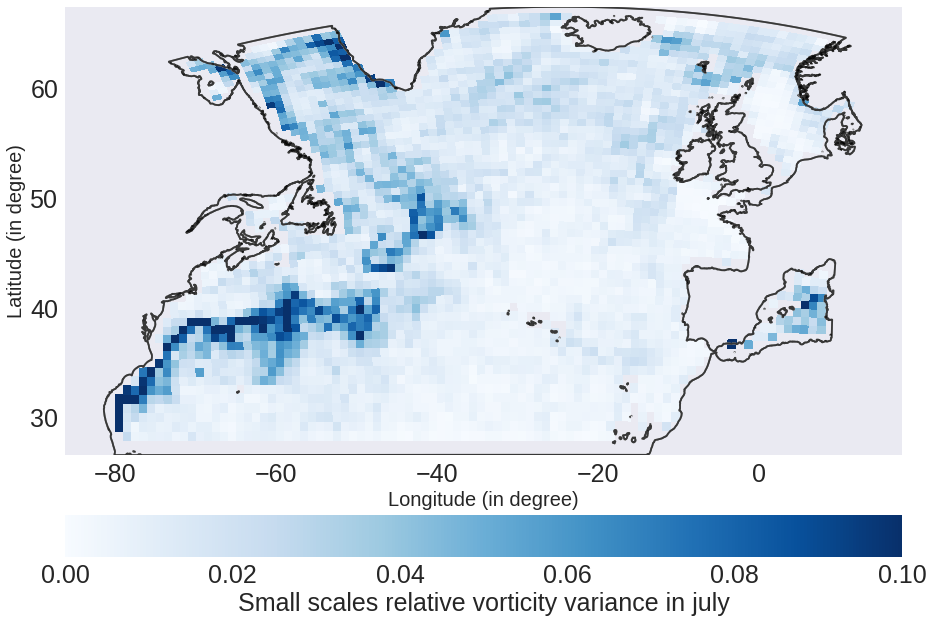

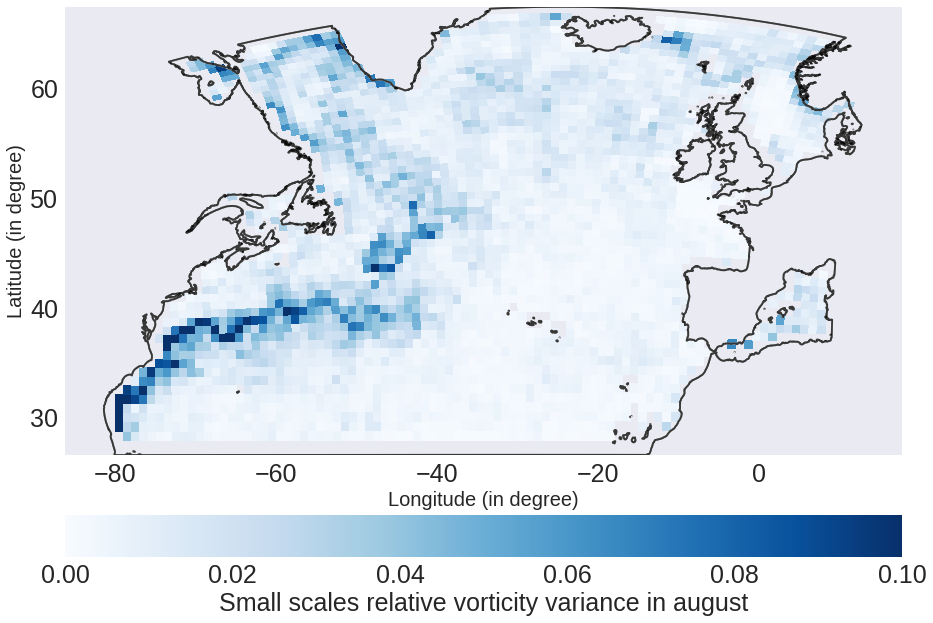

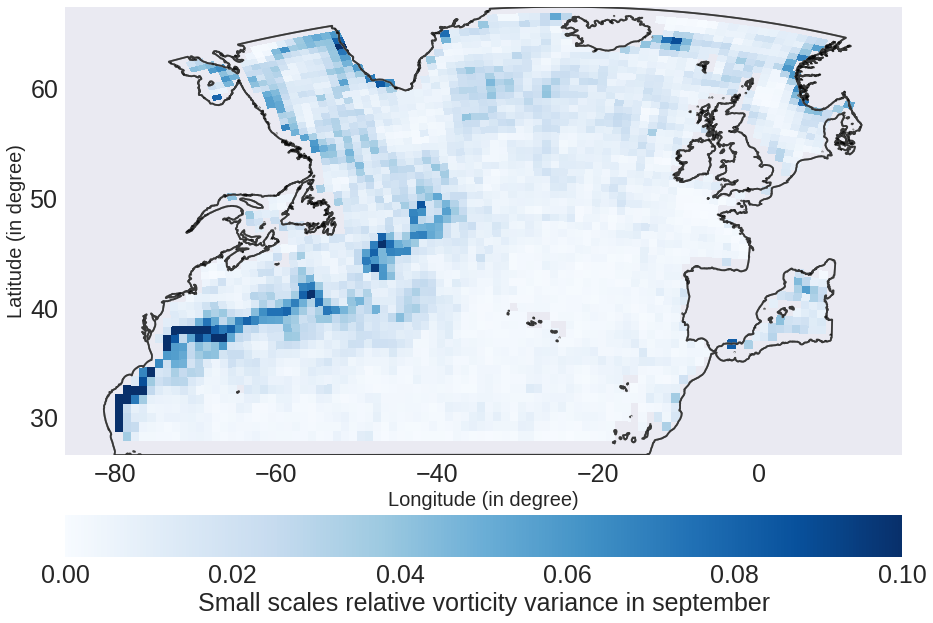

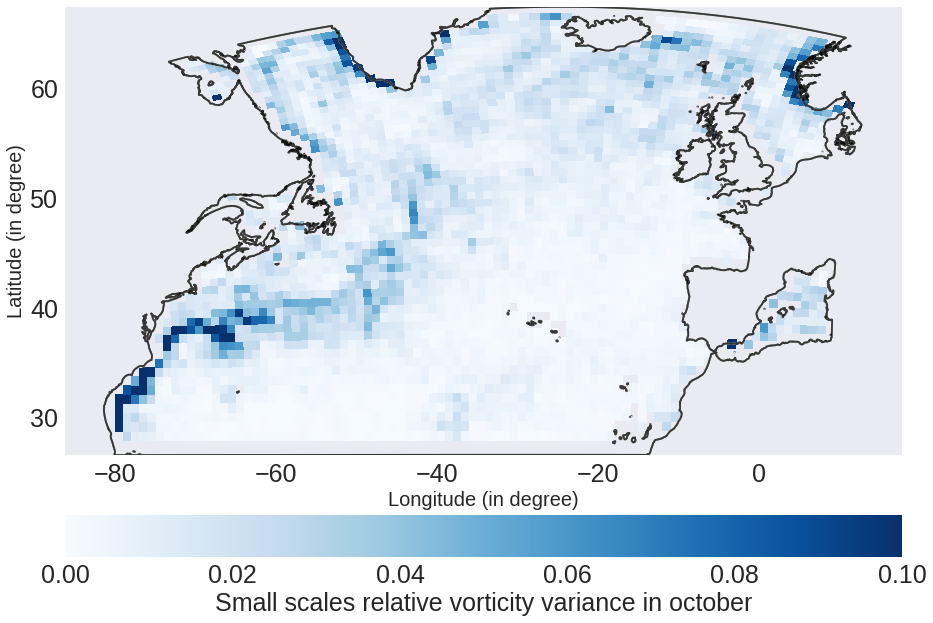

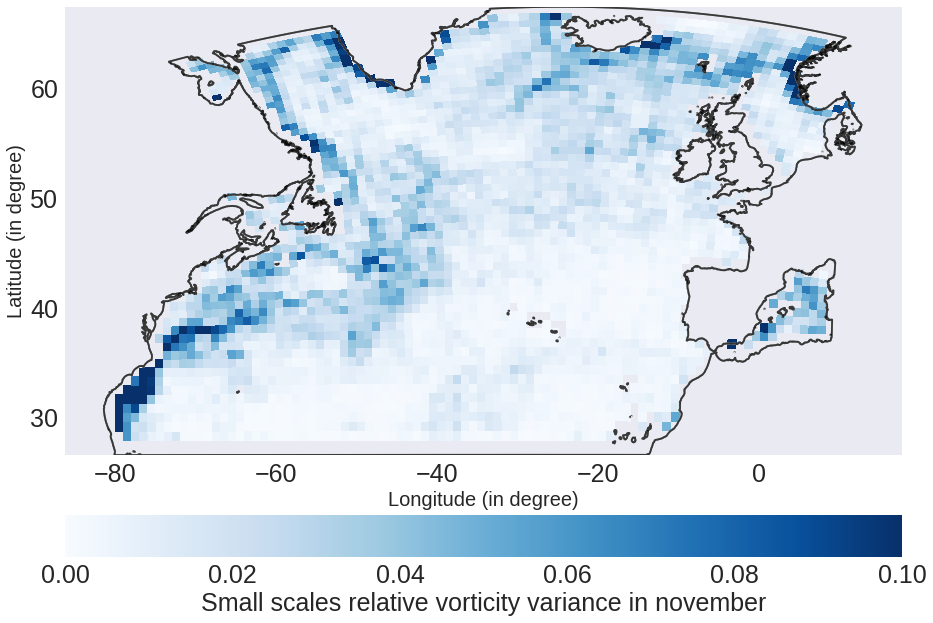

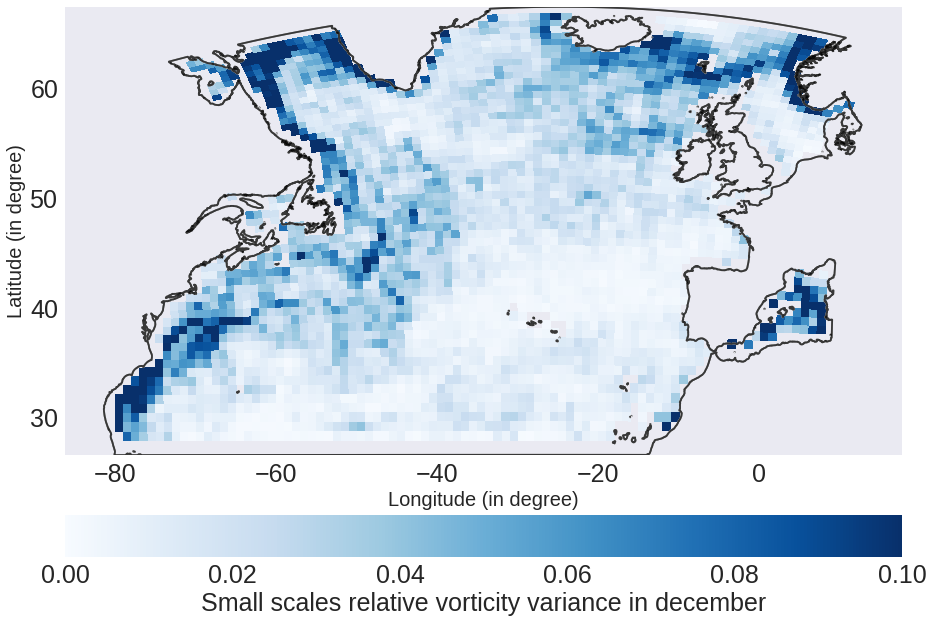

In [10]:
dir="/media/extra/DATA/NATL60/NATL60-CJM165-S/filt/"

for mm in np.arange(12):
    month = {1 : 'january',
           2 : 'february',
           3 : 'march',
           4 : 'april',
           5 : 'may',
           6 : 'june',
           7 : 'july',
           8 : 'august',
           9 : 'september',
           10 : 'october',
           11 : 'november',
           12 : 'december',
    }
    
    m=str(mm+1).zfill(2)
    if mm <9:
        year='2013'
    else:
        year='2012'
    filt_files='NATL60-CJM165_y'+year+'m'+str(m)+'d*.1d_socurloverf_filt-n80-f0.0125.nc'
    tf_files=dir+filt_files
    loncrsm, latcrsm, boxvarcurl, hpvarm = fine_scale_variance(tf_files)
    plot_fine_scale_variance(boxvarcurl,loncrsm, latcrsm,navlon,navlat,hpvarm,month[mm+1])

In [11]:
def plot_from_file(mm):

    dir="/media/extra/DATA/NATL60/NATL60-CJM165-S/filt/"
    month = {1 : 'january',
           2 : 'february',
           3 : 'march',
           4 : 'april',
           5 : 'may',
           6 : 'june',
           7 : 'july',
           8 : 'august',
           9 : 'september',
           10 : 'october',
           11 : 'november',
           12 : 'december',
    }
    
    m=str(mm+1).zfill(2)
    if mm <9:
        year='2013'
    else:
        year='2012'
    filt_files='NATL60-CJM165_y'+year+'m'+str(m)+'d*.1d_socurloverf_filt-n80-f0.0125.nc'
    tf_files=dir+filt_files
    loncrsm, latcrsm, boxvarcurl, hpvarm = fine_scale_variance(tf_files)
    fig=plot_fine_scale_variance(boxvarcurl,loncrsm, latcrsm,navlon,navlat,hpvarm,month[mm+1]);
    return fig

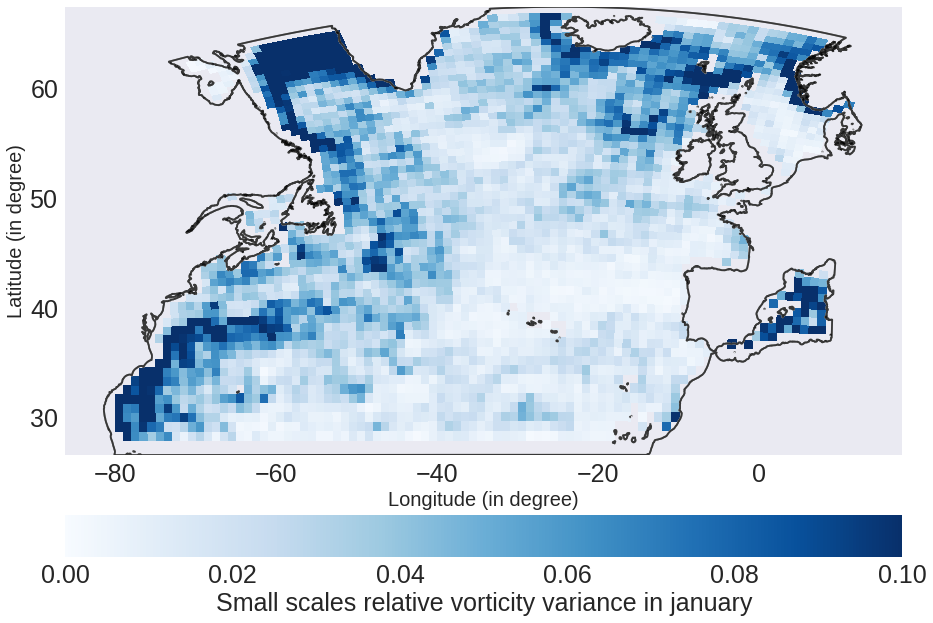

In [12]:
plot_from_file(0)

In [13]:
def plot_fine_scale_variance(ax,var,loncrs,latcrs,lon,lat,hpvarm,month):
    ''' map of the averaged fine scale variance
    '''
    cont=np.isnan(hpvarm)

    pcolor = ax.pcolormesh(loncrs,latcrs,ma.masked_invalid(var),cmap=seq_cmap,vmin=0,vmax=0.1,alpha=1)
    ax.tick_params(labelsize=25)
    ax.contour(lon,lat,cont,alpha=0.5,linewidth=0.000001,antialiased=True)
    cbar = plt.colorbar(pcolor,orientation='horizontal',pad=0.1)
    cbar.ax.tick_params(labelsize=35)
    ax.set_xlabel('Longitude (in degree)',fontsize=20)
    ax.set_ylabel('Latitude (in degree)',fontsize=20)
    cbar.ax.tick_params(labelsize=25)
    cbar.set_label('Small scales relative vorticity variance in '+month,fontsize=25)
    plt.savefig('fine_scale_variance_socurloverf_NATL60-CJM165_'+month+'.png')

def plot_from_file(ax,mm):

    dir="/media/extra/DATA/NATL60/NATL60-CJM165-S/filt/"
    month = {1 : 'january',
           2 : 'february',
           3 : 'march',
           4 : 'april',
           5 : 'may',
           6 : 'june',
           7 : 'july',
           8 : 'august',
           9 : 'september',
           10 : 'october',
           11 : 'november',
           12 : 'december',
    }
    
    m=str(mm+1).zfill(2)
    if mm <9:
        year='2013'
    else:
        year='2012'
    filt_files='NATL60-CJM165_y'+year+'m'+str(m)+'d*.1d_socurloverf_filt-n80-f0.0125.nc'
    tf_files=dir+filt_files
    loncrsm, latcrsm, boxvarcurl, hpvarm = fine_scale_variance(tf_files)
    fig=plot_fine_scale_variance(fig,boxvarcurl,loncrsm, latcrsm,navlon,navlat,hpvarm,month[mm+1]);
    return fig

from matplotlib import animation, rc
from IPython.display import HTML


fig = plt.figure(figsize=(20, 15))
ax = plt.subplot(111)
ax.autoscale(tight=True)
ims = []
for i in range(12):
    im = plot_from_file(ax,i)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=False, repeat=False)
plt.close()

HTML(ani.to_jshtml())



/home/albert/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


AttributeError: 'NoneType' object has no attribute 'canvas'

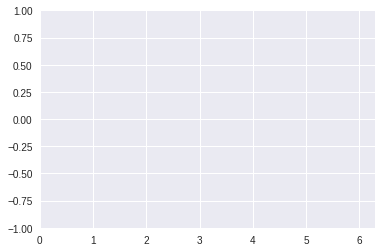

In [14]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
ax.axis([0,2*np.pi,-1,1])
l, = ax.plot([],[])

def animate(i):
    l.set_data(t[:i], x[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))

from IPython.display import HTML
HTML(ani.to_jshtml())